d:\Users\epiph\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Users\epiph\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 5)


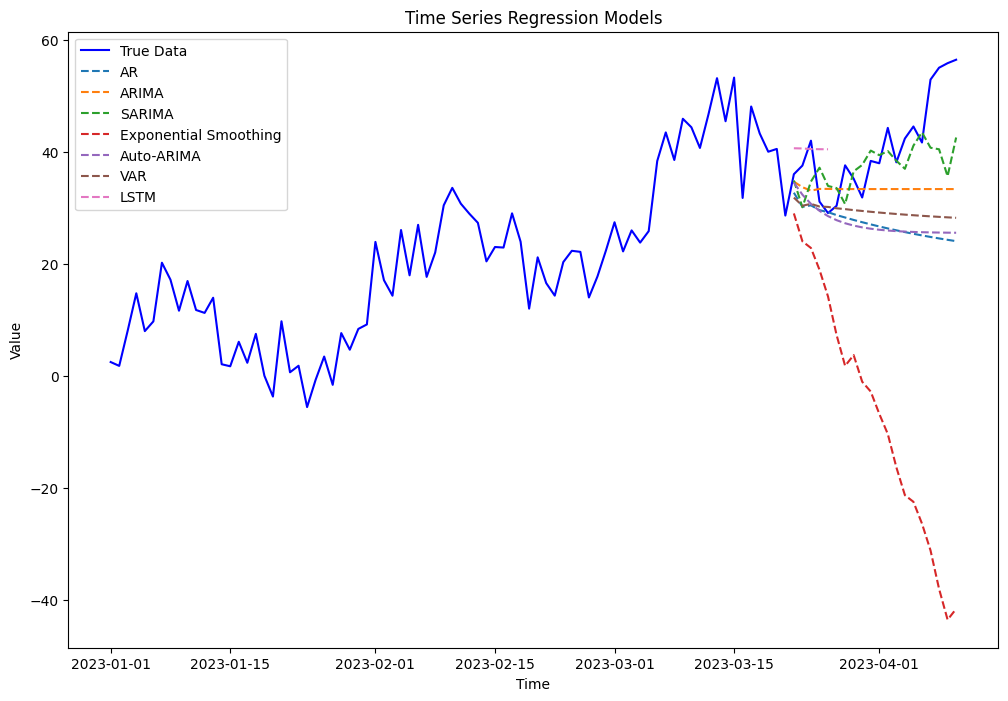

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import VAR
from pmdarima import auto_arima
# from fbprophet import Prophet 支持季节性与节假日效应。
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Generate synthetic time series data
np.random.seed(42)
time = np.arange(100)
data = 0.5 * time + 10 * np.sin(0.2 * time) + np.random.randn(100) * 5
series = pd.Series(data, index=pd.date_range("2023-01-01", periods=100))

# Split into train and test
train, test = series[:80], series[80:]

# 1. AR Model
ar_model = ARIMA(train, order=(2, 0, 0)).fit()
ar_forecast = ar_model.forecast(steps=20)

# 2. ARIMA Model
arima_model = ARIMA(train, order=(2, 1, 2)).fit()
arima_forecast = arima_model.forecast(steps=20)

# 3. SARIMA Model
sarima_model = SARIMAX(train, order=(2, 1, 2), seasonal_order=(1, 1, 1, 12)).fit()
sarima_forecast = sarima_model.forecast(steps=20)

# 4. Exponential Smoothing
ets_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).fit()
ets_forecast = ets_model.forecast(steps=20)

# 5. Auto-ARIMA
auto_arima_model = auto_arima(train, seasonal=True, m=12, trace=False, error_action="ignore")
auto_arima_forecast = auto_arima_model.predict(n_periods=20)

# # 6. Prophet
# df_prophet = train.reset_index().rename(columns={"index": "ds", 0: "y"})
# prophet_model = Prophet()
# prophet_model.fit(df_prophet)
# future = prophet_model.make_future_dataframe(periods=20)
# prophet_forecast = prophet_model.predict(future)["yhat"].iloc[-20:].values

# 7. VAR Model
# VAR requires at least two variables; simulate an additional series
train_var = pd.DataFrame({"y1": train.values, "y2": train.values + np.random.randn(len(train))})
var_model = VAR(train_var)
var_results = var_model.fit(2)
lag_order = var_results.k_ar  # Get lag order
var_forecast = var_results.forecast(y=train_var.values[-lag_order:], steps=20)
var_forecast = var_forecast[:, 0]  # Use the first variable's forecast

# 8. LSTM (PyTorch)
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Prepare data for LSTM
look_back = 5
X_lstm = [data[i : i + look_back] for i in range(len(train) - look_back)]
y_lstm = [data[i + look_back] for i in range(len(train) - look_back)]
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Generate test data with consistent shape
X_lstm_test = [data[i - look_back : i] for i in range(len(data) - look_back + 1, len(data) + 1)]
X_lstm_test = np.array(X_lstm_test, dtype=np.float32)
print(X_lstm_test.shape)

# Convert to PyTorch tensors
X_train_lstm = torch.tensor(X_lstm, dtype=torch.float32).unsqueeze(-1)
y_train_lstm = torch.tensor(y_lstm, dtype=torch.float32).unsqueeze(-1)
X_test_lstm = torch.tensor(X_lstm_test, dtype=torch.float32).unsqueeze(-1)

# Train LSTM model
lstm_model = LSTM(input_size=1, hidden_size=50, num_layers=1, output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)

epochs = 200
for epoch in range(epochs):
    lstm_model.train()
    outputs = lstm_model(X_train_lstm)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_lstm)
    loss.backward()
    optimizer.step()

# Forecast with LSTM
lstm_model.eval()
lstm_forecast = lstm_model(X_test_lstm).detach().numpy().flatten()

# Visualize results
plt.figure(figsize=(12, 8))
plt.plot(series, label="True Data", color="blue")
plt.plot(test.index, ar_forecast, label="AR", linestyle="--")
plt.plot(test.index, arima_forecast, label="ARIMA", linestyle="--")
plt.plot(test.index, sarima_forecast, label="SARIMA", linestyle="--")
plt.plot(test.index, ets_forecast, label="Exponential Smoothing", linestyle="--")
plt.plot(test.index, auto_arima_forecast, label="Auto-ARIMA", linestyle="--")
# plt.plot(test.index, prophet_forecast, label="Prophet", linestyle="--")
plt.plot(test.index, var_forecast, label="VAR", linestyle="--")
plt.plot(test.index[:len(lstm_forecast)], lstm_forecast, label="LSTM", linestyle="--")
plt.legend()
plt.title("Time Series Regression Models")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()


以下是代码中实现的时间序列回归模型的总结，包括每个模型的特点、适用场景和优缺点。

---

### **1. 自回归模型 (AR)**
- **特点**:
  - 基于序列的过去值进行预测。
  - 假设序列是平稳的，过去值可以描述未来。
- **适用场景**:
  - 时间序列平稳，且对模型解释性有要求。
- **优缺点**:
  - **优点**: 模型简单、计算效率高。
  - **缺点**: 仅适用于平稳数据，无法处理趋势和季节性。

---

### **2. 自回归积分滑动平均模型 (ARIMA)**
- **特点**:
  - 包括自回归 (AR)、差分 (I)、滑动平均 (MA) 三部分。
  - 能处理非平稳时间序列，通过差分移除趋势和季节性。
- **适用场景**:
  - 数据有一定趋势或非平稳性，且季节性不显著。
- **优缺点**:
  - **优点**: 灵活性高，可捕捉复杂的时间序列模式。
  - **缺点**: 参数选择较复杂，计算效率较低。

---

### **3. 季节性自回归积分滑动平均模型 (SARIMA)**
- **特点**:
  - 在 ARIMA 基础上增加季节性处理。
  - 通过季节性参数捕捉周期性特征。
- **适用场景**:
  - 季节性显著的时间序列，如季度销售、气温变化。
- **优缺点**:
  - **优点**: 能处理复杂的季节性模式。
  - **缺点**: 参数复杂，训练时间较长。

---

### **4. 指数平滑模型 (Exponential Smoothing, ETS)**
- **特点**:
  - 使用指数加权方式平滑数据。
  - 能捕捉趋势和季节性特征。
- **适用场景**:
  - 数据简单且具有趋势或季节性。
- **优缺点**:
  - **优点**: 模型简单，计算效率高。
  - **缺点**: 不适合复杂非线性模式。

---

### **5. 自动 ARIMA (Auto-ARIMA)**
- **特点**:
  - 自动选择 ARIMA 的最佳参数。
  - 通过网格搜索简化参数选择过程。
- **适用场景**:
  - 数据具有一定趋势或季节性，且需要快速建模。
- **优缺点**:
  - **优点**: 自动化程度高，适合初学者。
  - **缺点**: 计算开销大，对大规模数据较慢。

---

### **6. 向量自回归模型 (VAR)**
- **特点**:
  - 多变量时间序列建模。
  - 考虑多个时间序列之间的相互作用。
- **适用场景**:
  - 多变量时间序列分析，如经济数据、气象数据。
- **优缺点**:
  - **优点**: 能捕捉变量之间的动态交互。
  - **缺点**: 对滞后选择敏感，模型复杂度较高。

---

### **7. 长短期记忆网络 (LSTM)**
- **特点**:
  - 基于循环神经网络（RNN），能捕捉长期依赖关系。
  - 通过门机制处理长时间序列。
- **适用场景**:
  - 非线性和长时间依赖的时间序列，如股票价格预测。
- **优缺点**:
  - **优点**: 能处理复杂的非线性和长时间依赖。
  - **缺点**: 对数据规模敏感，训练时间较长，需要较多计算资源。

---

### **模型选型建议**

| **任务特点**                    | **推荐模型**                |
|--------------------------------|-----------------------------|
| 数据平稳，无趋势或季节性         | AR                         |
| 数据非平稳，具有一定趋势         | ARIMA                      |
| 数据有显著季节性                 | SARIMA                     |
| 数据简单且具有趋势或季节性       | Exponential Smoothing      |
| 参数选择不明确                  | Auto-ARIMA                 |
| 多变量时间序列                  | VAR                        |
| 数据复杂，长时间依赖显著         | LSTM                       |


